# Verifying the Dataset

## Imports

In [14]:
import sys
if '..' not in sys.path:
	sys.path.append('..')

In [36]:
import json
import os
import shutil
from itertools import product
from typing import Iterable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import reload
from PIL import Image, ImageDraw, ImageFont, ImageOps

In [37]:
%reload vgg_image_annotation
from vgg_image_annotation.v2 import ShapeAttributes, get_bounding_box


## Constants

In [16]:
UNKNOWN = 'Unknown'
VALUES = ['5', '10', '25', '50', '100']
SIDES = ['Up', 'Down']
EDITIONS = ['Old', 'New']
SORTED_COINS_DIR = '../sorted_coins'
DATASET_PATH = os.environ['COINS_DATASET_PATH']


## Load JSON

In [39]:
from typing import Dict
from vgg_image_annotation.v2 import ImageMetadata, RegionAttributes, load_via_v2_file

json_data = load_via_v2_file(DATASET_PATH)

# Image metadata is where we have the regions we need
images_data: Dict[str, ImageMetadata] = json_data['_via_img_metadata']

## Dataset Balancing Analysis


Let's verify if the dataset is balanced between classes.

### Create Dataframe


In [19]:
def insert(df, row):
	# Insert the row into the dataframe
	df.loc[len(df)] = row

In [20]:
# Load dataframe df with all the image data
from colorama import Fore, Back, Style

df = pd.DataFrame(columns=['ImageName', 'ImageId',
                  'RegionId', 'Value', 'Edition', 'Side'])

# Get number of coins for each type
for image in images_data:
    for regionId, region in enumerate(images_data[image]['regions']):
        attributes = region['region_attributes']
        # add row to dataframe with image name, region id, coin value, edition and side
        try:
            insert(df, {
                # image name is just the first 19 characters of the image path
                'ImageName': image[:19],
                'ImageId': image,
                'RegionId': regionId + 1,
                'Value': attributes.get('Value', UNKNOWN),
                'Edition': attributes.get('Edition', UNKNOWN),
                'Side': attributes.get('Side', UNKNOWN),
                # 'FullName': f'{attributes["Value"]} {attributes["Edition"]} {attributes["Side"]}'
            })
        except:
            print(Fore.RED + Style.BRIGHT +
                  f'Error on image {image[:19]} region {regionId + 1}', )

df.head()


,ImageName,ImageId,RegionId,Value,Edition,Side
0,20220827_125135.jpg,20220827_125135.jpg5530448,1,25,New,Up
1,20220827_125135.jpg,20220827_125135.jpg5530448,2,10,New,Up
2,20220827_125135.jpg,20220827_125135.jpg5530448,3,50,Old,Up
3,20220827_125135.jpg,20220827_125135.jpg5530448,4,5,New,Up
4,20220827_125135.jpg,20220827_125135.jpg5530448,5,5,New,Up


### Remove the columns Side and Edition that are incomplete

In [22]:
df = df.drop(columns=['Side', 'Edition'])

### Remove uncertain classes

In [23]:
unknown_coins = len(df[(df['Value'] == UNKNOWN)])
print(f'Number of uknown coins: {unknown_coins}')

Number of uknown coins: 203


In [24]:
# Those classes are the ones that we are not sure about the value of the coin.
print(f'Number of coins: {len(df)}')
df = df[df['Value'] != UNKNOWN]
print(f'Number of coins without uncertain: {len(df)}')

Number of coins: 10974
Number of coins without uncertain: 10771


### Analyze the distribution of coins

<AxesSubplot: >

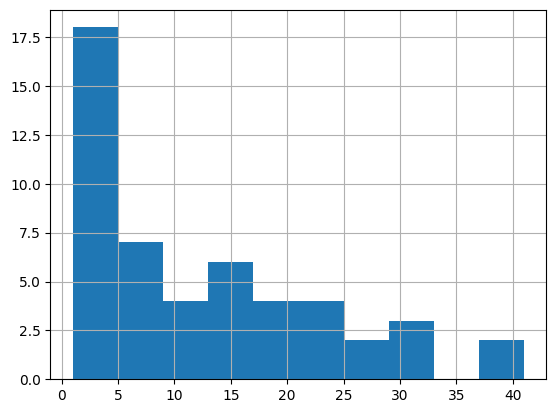

In [34]:
# How many coins per image
df['ImageName'].value_counts().value_counts().hist()

<AxesSubplot: title={'center': 'Coin Values'}, ylabel='Value'>

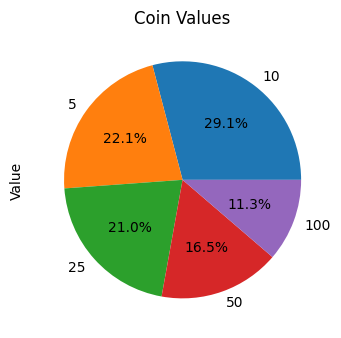

In [35]:
# Create charts
figsize = (13,13)
# Create a pie chart for the coin values
plt.subplot(1, 3, 1)
plt.title('Coin Values')
df[df['Value'] != UNKNOWN]['Value'].value_counts().plot.pie(autopct='%1.1f%%', figsize=figsize)

## Create a pie chart for the coin sides
#plt.subplot(1, 3, 2)
#plt.title('Coin Sides')
#df[df['Side'] != UNKNOWN]['Side'].value_counts().plot.pie(autopct='%1.1f%%', figsize=figsize)
#
## Create a pie chart for the coin editions
#plt.subplot(1, 3, 3)
#plt.title('Coin Editions')
#df[df['Edition'] != UNKNOWN]['Edition'].value_counts().plot.pie(autopct='%1.1f%%', figsize=figsize)

In [29]:
#describe the column value
df['Value'].describe()

count     10771
unique        5
top          10
freq       3134
Name: Value, dtype: object

## Verify if the coins are correctly classified


In [41]:

def crop_region(image: Image.Image, region_id: int, shape: ShapeAttributes) -> Image.Image:
    """
    Crops the region from the image, and returns the cropped image.
    """

    # Get the bounding box for the region
    topleft, bottomright = get_bounding_box(shape, size=image.size)

    return image.crop((*topleft, *bottomright))


In [42]:
# Remove dir if it exists
if os.path.exists(SORTED_COINS_DIR):
    # Remove recursively
    shutil.rmtree(SORTED_COINS_DIR)

os.mkdir(SORTED_COINS_DIR)

DATASET_DIR = os.path.dirname(DATASET_PATH)
BASE_PATH = json_data['_via_settings']['core']['default_filepath']

count = len(images_data.values())

for image_idx, metadata in enumerate(images_data.values()):
    filename = metadata['filename']
    percent = int((image_idx + 1) / count * 100)
    
    print(f'Processing {filename}... ({percent}%)')

    path = os.path.join(DATASET_DIR, BASE_PATH, filename)
    with Image.open(path) as image:
        image = ImageOps.exif_transpose(image)

        for region_id, region in enumerate(metadata['regions']):

            attributes = region['region_attributes']
            directory = f'{SORTED_COINS_DIR}/{attributes.get("Value", UNKNOWN)}'

            if not os.path.isdir(directory):
                os.mkdir(directory)

            crop = crop_region(image, region_id, region['shape_attributes'])
            crop.save(f'{directory}/{filename}_{region_id}.png')


Processing 20220827_125135.jpg... (0%)
Processing 20220827_125146.jpg... (0%)
Processing 20220827_125153.jpg... (0%)
Processing 20220827_125223.jpg... (0%)
Processing 20220827_125232.jpg... (0%)
Processing 20220827_125250.jpg... (0%)


KeyboardInterrupt: 